### Sentiment Analysis – Take home Assignment
#### Date : 24.05.2024
#### Index No: SE/2017/040

# Loading Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
import re #regex

#stemming
from nltk.stem import PorterStemmer

#stopwords
from nltk.corpus import stopwords

from sklearn import svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#visualizations
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# a) Use the IMDB movie reviews dataset provided. Read the csv data file to a Pandas dataframe and take a sample of 10,000 reviews as your main dataset used for Sentiment Analysis. Use stratified sampling to ensure that the classes are balanced. Clean the data in appropriate ways. Print the number of reviews which are positive and the number that are negative in order to gauge the dimensions of the dataset.

# Loading Data

In [3]:
# from google.colab import drive

# drive.mount('/content/gdrive')

In [4]:
# path = "gdrive/MyDrive/big_data_assignment/IMDB_Dataset.csv"
path = "./IMDB_Dataset.csv"

In [5]:
df = pd.read_csv(path)

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
len(df)

50000

# Creating the main data sets       

In [8]:
df_pos = df[df['sentiment'] == 'positive'] # filtering out positive reviews

In [9]:
df_pos.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive


In [10]:
len(df_pos)

25000

In [11]:
df_neg = df[df['sentiment'] == 'negative'] # filtering out negative reviews

In [12]:
len(df_neg)

25000

### Creating main data set

In [13]:
_, main_data_set_pos = train_test_split(df_pos, test_size = 0.2, random_state = 42) # getting 0.2% of the positive reviews
_, main_data_set_neg = train_test_split(df_neg, test_size = 0.2, random_state = 42) # getting 0.2% of the negative reviews

In [14]:
len(main_data_set_pos)

5000

In [15]:
len(main_data_set_neg)

5000

In [16]:
main_data_set = pd.concat([main_data_set_pos, main_data_set_neg])

In [17]:
main_data_set

,review,sentiment
13886,I don't know how or why this film has a meager...,positive
48027,For a long time it seemed like all the good Ca...,positive
19536,Terry Gilliam's and David Peoples' teamed up t...,positive
27232,What is there to say about an anti-establishme...,positive
28001,This movie was made only 48 years after the en...,positive
...,...,...
17119,Very interesting to find another reviewer who ...,negative
23568,When I began watching The Muppets Take Manhatt...,negative
8035,i was disappointed in this documentary.i thoug...,negative
42255,"The acting wasn't great, the story was full of...",negative


### Created main data set using stratified sampling and it contains 5000 reviews for each negative and positive sentiments.

# Cleaning data

### Creating data classes

In [18]:
stop_words = set(stopwords.words('english'))
stemmer = nltk.PorterStemmer()
def preprocess_text(text, stop_words = stop_words, stemmer = stemmer):
    text = text.lower() # converting text to lower case
    
    text = nltk.word_tokenize(text) # tokenizing text

    text = [word for word in text if word not in stop_words] # removing stop words

    text = [stemmer.stem(word) for word in text] # stemming words

    # text = [word for word in text if len(word) > 2]
    
    text = " ".join(text) #joining text 
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) #removing non alphanumeric characters
    text = re.sub(r'\d+', '', text) # removing numbers
    text = re.sub(r'br', '', text) # removing residue br from <br/> tag
    text = re.sub(r'\b\w\b', '', text) # removing single character letters
    text = re.sub('\s+', ' ', text).strip() # removing extra spaces

    return text

# Class review to hold the text and sentiment
class Review:
    def __init__(self, text, sentiment):
        self.text = preprocess_text(text)
        self.sentiment = sentiment

# Class Container to hold reviews, so manipulating them will be easier latter
class Container:
    def __init__(self, reviews):
        self.reviews = reviews
        
    def get_text(self):
        return [x.text for x in self.reviews]
    
    def get_sentiment(self):
        return [x.sentiment for x in self.reviews]
    
    def get_vectorized_text(self, vectorizer):
        return vectorizer.transform(self.get_text())
    

In [19]:
main_data_reviews = []

for index, row in main_data_set.iterrows():
    main_data_reviews.append(Review(row.review, row.sentiment))

In [20]:
main_data_container = Container(main_data_reviews)

In [21]:
main_data_container.get_text()[0]

'nt know film meager rate imdb film accompani curiou blue masterwork thing let film nt like process film nt like psycholog expect hardcor pornograph ramming nt film want watch unwind film want see like masterpiec time attent care summari may contain spoiler two main thing film blend whole film within film thing way sometim forget fiction nt real film like mani film one polit documentari social system sweden time lot way still relev today interview done young woman name lena narr filmmak vilgot sjoman make film deal relationship star film never got involv peopl suppos work with film vilgot make young woman name lena ie young polit activ make documentari ie also come age sexual freedom that magnific sheer illianc curiou yellowblu three element cut togeth one moment watch interview polit next watch interview behind scene well sometim forget narrative anoth thing dynam yellow blue see one must see blue sequel ll tri explain best knowledg film done though great technique think yellow live t

In [22]:
main_data_set.iloc[0].review

'I don\'t know how or why this film has a meager rating on IMDb. This film, accompanied by "I am Curious: Blue" is a masterwork.<br /><br />The only thing that will let you down in this film is if you don\'t like the process of film, don\'t like psychology or if you were expecting hardcore pornographic ramming.<br /><br />This isn\'t a film that you will want to watch to unwind; it\'s a film that you want to see like any other masterpiece, with time, attention and care.<br /><br />******SUMMARIES, MAY CONTAIN A SPOILER OR TWO*******<br /><br />The main thing about this film is that it blends the whole film, within a film thing, but it does it in such a way that sometimes you forget that the fictions aren\'t real.<br /><br />The film is like many films in one:<br /><br />1. A political documentary, about the social system in Sweden at the time. Which in a lot of ways are still relevant to today. Interviews done by a young woman named Lena.<br /><br />2. A narrative about a filmmaker, Vi

# b) Create bag-of-words and TF-IDF representations of the reviews in the main-dataset above and use two relevant supervised learning algorithms to classify future reviews according to their sentiment. Print the confusion matrices of the four (04) resulting combinations for a held-out (test) dataset. (Split the data into training and testing sets, using 80% of the data for training and the rest for testing.)

In [23]:
len(df)

50000

In [24]:
count_vectorizer = CountVectorizer() # By vectorizing using count vectorizer we can obtain the bag of words representation
count_vectorizer.fit(main_data_container.get_text())

CountVectorizer()

In [25]:
tfid_vectorizer = TfidfVectorizer()
tfid_vectorizer.fit(main_data_container.get_text())

TfidfVectorizer()

In [26]:
len(count_vectorizer.get_feature_names_out())

45958

In [27]:
train, test = train_test_split(main_data_container.reviews, test_size = 0.2, random_state=42)

In [28]:
len(test)

2000

In [29]:
len(train)

8000

In [30]:
train_cont = Container(train)

In [31]:
test_cont = Container(test)

In [32]:
train_x_vectors_cv = train_cont.get_vectorized_text(count_vectorizer)
train_y = train_cont.get_sentiment()

In [33]:
test_x_vectors_cv = test_cont.get_vectorized_text(count_vectorizer)
test_y = test_cont.get_sentiment()

## Testing different models


## count vectorizer
### with svm 

In [34]:
clf_svc_cv = svm.SVC(kernel = 'linear')
clf_svc_cv.fit(train_x_vectors_cv, train_y)

SVC(kernel='linear')

In [35]:
pred_y_svc_cv = clf_svc_cv.predict(test_x_vectors_cv)

In [36]:
svc_cv_cm = confusion_matrix(test_y,pred_y_svc_cv)

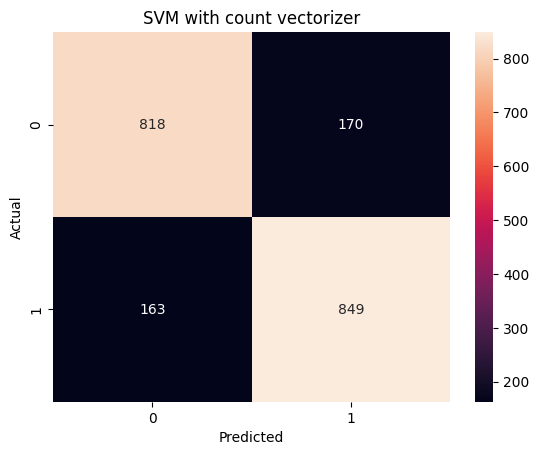

In [37]:
sns.heatmap(svc_cv_cm, annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM with count vectorizer")
plt.show()

In [38]:
svc_cv_accuracy = accuracy_score(test_y, pred_y_svc_cv)
svc_cv_accuracy

0.8335

In [39]:
print(classification_report(test_y, pred_y_svc_cv))

              precision    recall  f1-score   support

    negative       0.83      0.83      0.83       988
    positive       0.83      0.84      0.84      1012

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



### Naive Bayes 

In [40]:
clf_bayes_cv = MultinomialNB()
clf_bayes_cv.fit(train_x_vectors_cv.toarray(), train_y)

MultinomialNB()

In [41]:
pred_y_bayes_cv = clf_bayes_cv.predict(test_x_vectors_cv.toarray())

In [42]:
bayes_cv_cm = confusion_matrix(test_y, pred_y_bayes_cv)

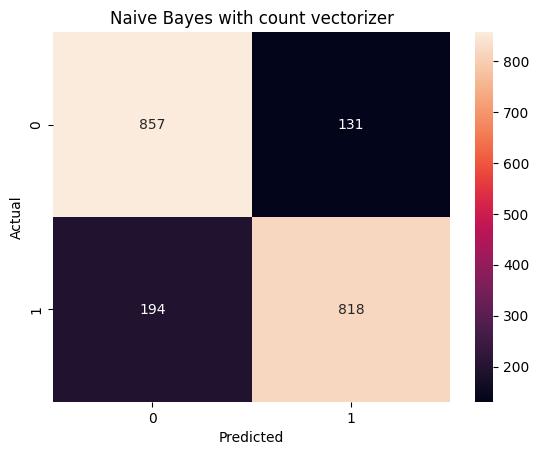

In [43]:
sns.heatmap(bayes_cv_cm, annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Naive Bayes with count vectorizer")
plt.show()

In [44]:
bayes_cv_accuracy = accuracy_score(test_y, pred_y_bayes_cv)
bayes_cv_accuracy

0.8375

In [45]:
print(classification_report(test_y, pred_y_bayes_cv))

              precision    recall  f1-score   support

    negative       0.82      0.87      0.84       988
    positive       0.86      0.81      0.83      1012

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



## Tfid Vectorizer

In [46]:
train_x_vectors_tf = train_cont.get_vectorized_text(tfid_vectorizer)
train_y = train_cont.get_sentiment()

In [47]:
test_x_vectors_tf = test_cont.get_vectorized_text(tfid_vectorizer)
test_y = test_cont.get_sentiment()

### with svm

In [48]:
clf_svc_tf = svm.SVC(kernel = 'linear')
clf_svc_tf.fit(train_x_vectors_tf, train_y)

SVC(kernel='linear')

In [49]:
pred_y_svc_tf = clf_svc_tf.predict(test_x_vectors_tf)

In [50]:
svc_tf_cm = confusion_matrix(test_y, pred_y_svc_tf)

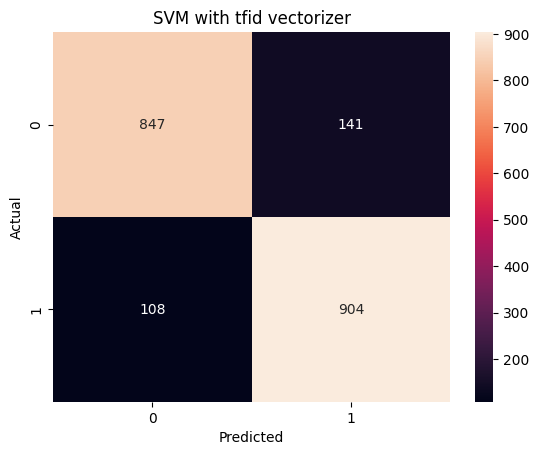

In [51]:
sns.heatmap(svc_tf_cm, annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM with tfid vectorizer")
plt.show()

In [52]:
svc_tf_accuracy = accuracy_score(test_y, pred_y_svc_tf)
svc_tf_accuracy

0.8755

In [53]:
print(classification_report(test_y, pred_y_svc_tf))

              precision    recall  f1-score   support

    negative       0.89      0.86      0.87       988
    positive       0.87      0.89      0.88      1012

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



### with naive bayes

In [54]:
clf_bayes_tf = MultinomialNB()
clf_bayes_tf.fit(train_x_vectors_tf.toarray(), train_y)

MultinomialNB()

In [55]:
pred_y_bayes_tf = clf_bayes_tf.predict(test_x_vectors_tf.toarray())

In [56]:
bayes_tf_cm = confusion_matrix(test_y, pred_y_bayes_tf)

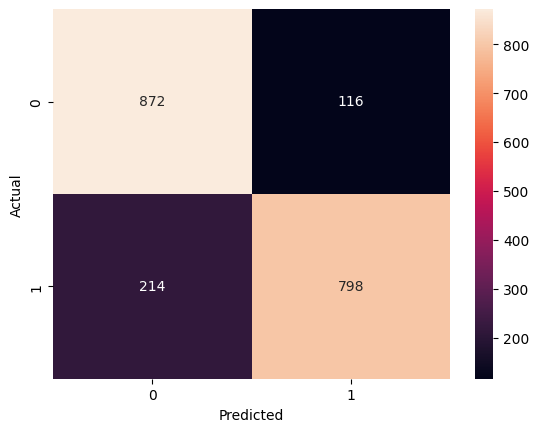

In [57]:
sns.heatmap(bayes_tf_cm, annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [58]:
bayes_tf_accuracy = accuracy_score(test_y, pred_y_bayes_tf)
bayes_tf_accuracy

0.835

In [59]:
print(classification_report(test_y, pred_y_bayes_tf))

              precision    recall  f1-score   support

    negative       0.80      0.88      0.84       988
    positive       0.87      0.79      0.83      1012

    accuracy                           0.83      2000
   macro avg       0.84      0.84      0.83      2000
weighted avg       0.84      0.83      0.83      2000



In [60]:
print(f"Accuracy of svm model with count vectorized text: {svc_cv_accuracy}")
print(f"Accuracy of bayes model with count vectorized text: {bayes_cv_accuracy}")
print(f"Accuracy of svm model with tfid vectorized text: {svc_tf_accuracy}")
print(f"Accuracy of bayes model with tfid vectorized text: {bayes_tf_accuracy}")

Accuracy of svm model with count vectorized text: 0.8335
Accuracy of bayes model with count vectorized text: 0.8375
Accuracy of svm model with tfid vectorized text: 0.8755
Accuracy of bayes model with tfid vectorized text: 0.835


# c) Suggest any strategies you may use to improve the performance of the above classifier (apart from using deep learning). Implement your suggestions as improvements to the above models and print the confusion matrix of the best representation and model you get.

### Since simple vector machine (SVM) performed better with tfid vectorizer, svm model is selected to improve the performace using tfid vectorizer

### First tried out grid search cv to fine tune the svm model

In [61]:
parameters = {'kernel': ('linear', 'rbf'), 'C': (0.1, 1, 10), 'gamma': ('scale', 'auto')}

clf_gridSearch = GridSearchCV(svm.SVC(), parameters, cv=5, n_jobs=-1) # n_jobs = -1 to use all cpus to run jobs parallely

In [62]:
clf_gridSearch.fit(train_x_vectors_tf, train_y)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': (0.1, 1, 10), 'gamma': ('scale', 'auto'),
                         'kernel': ('linear', 'rbf')})

In [63]:
clf_gridSearch.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

In [64]:
pred_y_gridSearchCV = clf_gridSearch.predict(test_x_vectors_tf)

In [65]:
gridSearchCV_accuracy = accuracy_score(test_y, pred_y_gridSearchCV)
gridSearchCV_accuracy

0.8755

In [66]:
svc_tf_accuracy

0.8755

### There is no significant improvement in accuracy after applying grid search cv, so decided to use bagging classifier to improve the performance

### Testing with bagging

In [67]:
bagging_clf_svc_tf = BaggingClassifier(estimator=svm.SVC(kernel='linear'), n_estimators=10, random_state=42).fit(train_x_vectors_tf, train_y)

In [68]:
pred_y_bagging_svc = bagging_clf_svc_tf.predict(test_x_vectors_tf)

In [69]:
bagging_accuracy = accuracy_score(test_y, pred_y_bagging_svc)

In [70]:
bagging_accuracy

0.877